# Introduction

The following notebook is work-in-progress for the CORD-19-research-challenge on Kaggle.  
Our goal is to be able to search the dataset and find some answers to the tasks that are defined on Kaggle. We are usind mutiple embbeddings such as word2Vec or a simple td-idf on the papers.

## Dataset

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records  

# Setup

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [5]:
os.chdir('/content/drive/My Drive/CORD-19-research-challenge/')
os.listdir()

['noncomm_use_subset',
 'custom_license',
 'comm_use_subset',
 'biorxiv_medrxiv',
 'metadata.readme',
 'COVID.DATA.LIC.AGMT.pdf',
 'json_schema.txt',
 '.DS_Store',
 'metadata.csv']

## Import packages

In [6]:
!pip install -U sentence-transformers
!pip install mplcursors
!pip install bert-extractive-summarizer
!pip install spacy==2.1.3
!pip install neuralcoref
!python -m spacy download en_core_web_md

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.6/dist-packages (0.2.5.1)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import mplcursors
import json
import os
import glob
import re
import warnings
import random
import spacy
from itertools import chain

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from wordcloud import WordCloud

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import transformers

## Download the stopwords and special characters

In [8]:
nltk.download('stopwords')
stopwords.words('english')
nltk.download('punkt')
warnings.filterwarnings(action='once')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data processing

### Collect json files from the attached drive

In [0]:
 metadata_df = pd.read_csv('./metadata.csv', index_col='sha')
 filepath_biorxiv = './biorxiv_medrxiv/biorxiv_medrxiv/'
 filepath_noncomm = './noncomm_use_subset/noncomm_use_subset'
 filepath_comm = './comm_use_subset/comm_use_subset'
 filepath_custom = './custom_license/custom_license'

all_json_files = glob.glob(f'**/*.json', recursive=True)
biorxiv_json_files = glob.glob(f'biorxiv_medrxiv/**/*.json', recursive=True)
noncomm_json_files =  glob.glob(f'noncomm_use_subset/**/*.json', recursive=True)
comm_json_files = glob.glob(f'comm_use_subset/**/*.json', recursive=True)
custom_json_files = glob.glob(f'custom_license/**/*.json', recursive=True)


### Create dataframe
Create a dataframe with the abstracts

In [0]:
df_noncomm = create_df(noncomm_json_files)

In [0]:
df_comm = create_df(comm_json_files)
df_biorxiv = create_df(biorxiv_json_files)
df_custom = create_df(custom_json_files)

Filter the dataframes and format them for word2vec corpuses and visualizations with wordcloud

In [13]:
filtered_noncomm, filtered_noncomm_visualization = filter_df(df_noncomm)

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [0]:
filtered_biorxiv, filtered_biorxiv_visualization = filter_df(df_biorxiv)
filtered_comm, filtered_comm_visualization = filter_df(df_comm)
filtered_custom, filtered_custom_visualization = filter_df(df_custom)

filtered_meta, filtered_meta_visualization = filter_df(df)

## Helper functions

In [0]:
def create_df(file_list):
    contents = pd.DataFrame(columns=['text'])
    for file in file_list:
        with open(file) as json_file:
            data = json_file.read()
        
        obj = json.loads(data)
        if len(obj['abstract']) > 0:
            content = obj['abstract'][0]['text']
            contents = contents.append({'text': content}, ignore_index=True)
    return contents

def filter_df(df):
    filtered_list_visualization = []
    filtered_list = []
    for i in range(len(df)):
        filtered_list.append(simple_preprocess(df.text.values[i]))
        for w in simple_preprocess(df.text.values[i]):
            if w in stopwords.words('english') or len(w) < 2 or w.isnumeric():
                continue
        filtered_list_visualization.append(w)
    return filtered_list, filtered_list_visualization

In [0]:
def preprocessing(text, additional_stopwords=[]):
    preprocessed_text = simple_preprocess(text)
    filtered_list = []
    for token in preprocessed_text:
      if token in stopwords.words('english') or token in additional_stopwords  or token.isnumeric():
          continue
      filtered_list.append(token)
    return filtered_list

In [0]:
def get_preprocessed_text_from_files(json_files, attribute):
  preprocessed_text = [] 
  for json_file in json_files:
    with open(os.path.join(paper)) as json_file:
      paper_json = json.load(json_file)

      text = concat_json_properties(paper_json[attribute], 'text')
      preprocessed_text_ = preprocessing(str(text))
      preprocessed_text.append(preprocessed_text_)
  return preprocessed_text

In [0]:
def get_preprocessed_sentences_from_files(json_files, attribute):
  preprocessed_tokenized_sentences = []
  print(json_files)
  for json_file in json_files:
    with open(os.path.join(paper)) as json_file:
      json_object = json.load(json_file)

      # Preparing the dataset
      text = concat_json_properties_as_string(json_object[attribute], 'text')
      all_sentences = nltk.sent_tokenize(text)

      preprocessed_sentences = []
      for sentence in all_sentences:
        preprocessed_sentences.append(preprocessing(sentence))
        
      preprocessed_tokenized_sentences.extend(preprocessed_sentences)
  return preprocessed_tokenized_sentences

In [0]:
print(biorxiv_json_files)
test_file = biorxiv_json_files[0]

test = get_preprocessed_sentences_from_files([test_file], 'abstract')
print(test)

['biorxiv_medrxiv/biorxiv_medrxiv/874eaaeda2e803101ab952b3d9bc73426111b3d4.json', 'biorxiv_medrxiv/biorxiv_medrxiv/99dab788e984601ee4efcd1138926caf10c00dcf.json', 'biorxiv_medrxiv/biorxiv_medrxiv/dbefc8ad2a3de5d1696b7e604de8bce1da2ea8cd.json', 'biorxiv_medrxiv/biorxiv_medrxiv/b970b7a807f37678f91d4b989ffdb7d7606d754d.json', 'biorxiv_medrxiv/biorxiv_medrxiv/c8b6f2752a842dd9eb9c50a82112748ef10ba259.json', 'biorxiv_medrxiv/biorxiv_medrxiv/7395de48b2402e5e1561a93b99e8aae8728c6ff1.json', 'biorxiv_medrxiv/biorxiv_medrxiv/ce1d3a3103bbd8b5d7164259be03f1d6d3d5d251.json', 'biorxiv_medrxiv/biorxiv_medrxiv/0c27c0ddaa4761f6155838df81a88d24619720f8.json', 'biorxiv_medrxiv/biorxiv_medrxiv/6ad14ceec74dc9b3d3dc6db7fc319b9dc22dc546.json', 'biorxiv_medrxiv/biorxiv_medrxiv/05082393ba4c7ec530190dd887d99c74fd72f6d6.json', 'biorxiv_medrxiv/biorxiv_medrxiv/4346e63e692fcda7d3076d25df3e6f50b9c31407.json', 'biorxiv_medrxiv/biorxiv_medrxiv/bd8f57ea4aadeda075d557f566a1909d68e658c4.json', 'biorxiv_medrxiv/biorxiv_me

In [0]:
text = "This is a test. Let's see how this is working out. Hallo You it's great 15."
all_sentences = nltk.sent_tokenize(text)
print(all_sentences)
preprocessed_sentences = []
for sentence in all_sentences:
  preprocessed_sentences.append(preprocessing(sentence))

print(preprocessed_sentences)
# all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
# print(all_words)
# # Removing Stop Words
# for sentence in all_words):
#     print(i)
#     for word in i:

#     all_words[i] = preprocessing(all_words[i])
# preprocessed_tokens.append(all_words)
# print(preprocessed_tokens)

['This is a test.', "Let's see how this is working out.", "Hallo You it's great 15."]
[['test'], ['let', 'see', 'working'], ['hallo', 'great']]


/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [0]:
test = "hallo HOW, are You doing's ? up the Idea is to have viruses and convid stuff"
preprocess_test = preprocessing(test)

print(preprocess_test)

['hallo', 'idea', 'viruses', 'convid', 'stuff']


/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [0]:
def get_section_text(body_text, section_name_pattern):
    for section in body_text:
        section_name = section['section']
        if section_name_pattern in section_name.lower():
            return section['text']
        else:
            return 'none'

In [0]:
def concat_json_properties(json_list_element, property_name):
    concatenated_content = []
    for item in json_list_element:
        concatenated_content.append(item[property_name])
    return concatenated_content

In [0]:
def concat_json_properties_as_string(json_list_element, property_name):
    concatenated_content = ''
    for item in json_list_element:
        concatenated_content = concatenated_content + item[property_name]
    return concatenated_content

In [0]:
def visualize_word_frequencies(feature):
    wordcloud = WordCloud()
    frequency_dist = nltk.FreqDist(feature)
    sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50] 
    wordcloud.generate_from_frequencies(frequency_dist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [0]:
def get_dict_element_by_key(element_key):
    text = []
    for key in paper_dict:
        string = paper_dict[key][element_key]
        if (string != 'nan' and string != ''):
            text.append(string)
    return text

# Dataset analysis

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records



## Publications of papers

The dataset contains research papers that have been published in various journals

In [0]:
journal_names = get_dict_element_by_key('journal')
        
values, counts = np.unique(journal_names, return_counts=True)
print(values)
print(counts)

['ACS Omega' 'AIDS' 'AIDS Research and Human Retroviruses'
 'Acta Biomaterialia'
 'Acta Crystallographica Section F Structural Biology and Crystallization Communications'
 'Acta Otolaryngol' 'Acta Vet Scand' 'Active Coatings for Smart Textiles'
 'Adv Virol' 'Advances in Anesthesia' 'Advances in Genetics'
 'Advances in Pediatrics' 'Advances in Veterinary Medicine'
 'Advances in Virus Research' 'Alcohol' 'Allergy' 'Am J Trop Med Hyg'
 'American Journal of Hypertension'
 'American Journal of Infection Control'
 'American Journal of Obstetrics and Gynecology'
 'American Journal of Respiratory Cell and Molecular Biology'
 'Amino Acids' 'Anales de Pediatría' 'Anales de Pediatría Continuada'
 'Analytica Chimica Acta' 'Anim Front' 'Animal Agriculture'
 'Animal Feed Science and Technology'
 'Animal Models for the Study of Human Disease'
 "Annales Françaises d'Anesthésie et de Réanimation"
 'Annales de Pathologie' 'Annals of Emergency Medicine'
 'Annals of Oncology' 'Annals of Tourism Research' 

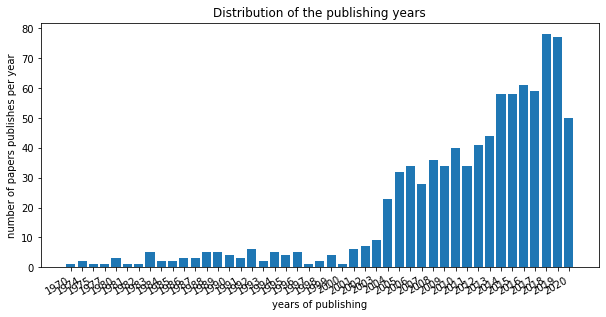

In [0]:
publish_years = []
for key in paper_dict:
    string_date = str(paper_dict[key]['publish_date'])
    if (string_date != 'nan' and string_date != ''):
        match = re.search('[0-9]{4}', string_date)
        
        if match:
            publish_year = match.group(0)
            publish_years.append(publish_year)
        else:
            print(string_date)
            
get_dict_element_by_key('journal')
# plot the distribution of the publishing years
x, y = np.unique(publish_years, return_counts=True)
fig = plt.figure(figsize=(10,5))
plot = fig.add_subplot()
plot.bar(x,y)
plt.gcf().autofmt_xdate()
plt.title("Distribution of the publishing years")
plt.xlabel("years of publishing")
plt.ylabel("number of papers publishes per year")

#mplcursors.cursor(hover=True)

plt.show()

## Topics

The dataset is not limited to papers specifically about COVID-19 but also covers topis about multiple other viruses. 

Achieving compliance with the International Health Regulations by overseas territories of the United Kingdom of Great Britain and Northern Ireland
Epidemiology of respiratory viral infections in people with acute respiratory tract infections in Africa: the VARIAFRICA systematic review and meta-analysis protocol
Prediction of cross-species infection propensities of viruses with receptor similarity
A comparative analysis of host responses to avian influenza infection in ducks and chickens highlights a role for the interferon-induced transmembrane proteins in viral resistance
Emerging infectious disease outbreaks: Old lessons and new challenges for obstetrician-gynecologists
Assessment of returning travellers with fever
Anti-Norovirus Therapeutics: A Patent Review (2010-2015)
Choindroitinase ABC I-Mediated Enhancement of Oncolytic Virus Spread and Anti Tumor Efficacy: A Mathematical Model
Alzheimer's disease Advax CpG - adjuvanted MultiTEP-based dual and single vaccines induce high- titer

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


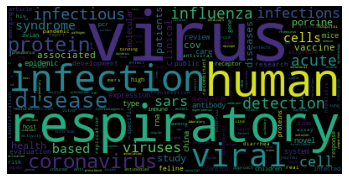

In [0]:
titles = get_dict_element_by_key('title')

titles_to_print = random.choices(titles, k=20)
print('\n'.join(titles_to_print))

topics = []
for title in titles:
  topics.extend(preprocessing(title, ['title', 'using', 'analysis']))

visualize_word_frequencies(topics)

In [0]:
titles = np.array(get_dict_element_by_key('title'))

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(titles)

# TODO: create clustering of title sbased on cosine similarity and visualize them (-> see https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Interactive-t-SNE

## Visualize the word frequencies

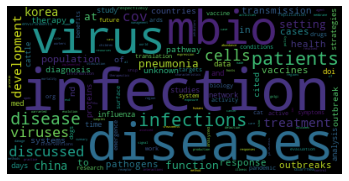

In [16]:
visualize_word_frequencies(filtered_noncomm_visualization)

In [0]:
visualize_word_frequencies(filtered_meta_visualization)

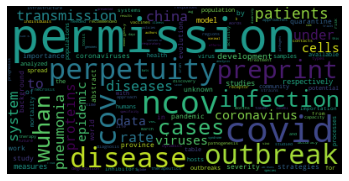

In [0]:
visualize_word_frequencies(filtered_biorxiv_visualization)

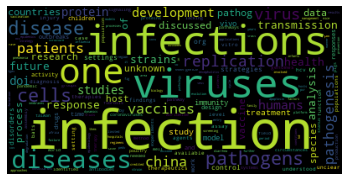

In [0]:
visualize_word_frequencies(filtered_comm_visualization)

In [0]:
visualize_word_frequencies(filtered_custom_visualization)

# Build word2vec models for the data sets

In [0]:

# build vocabulary and train model for the non_comm data set
noncomm_model = Word2Vec(
    filtered_noncomm,
    size=150,
    window=10,
    min_count=2,
    workers=10,
    iter=10)

In [0]:
# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    filtered_biorxiv,
    size=150,
    window=10,
    min_count=2,
    workers=10,
    iter=10)


In [0]:
# build vocabulary and train model for the comm data set
comm_model = Word2Vec(
    filtered_comm,
    size=150,
    window=10,
    min_count=2,
    workers=10,
    iter=10)

In [0]:
# build vocabulary and train model for the custom data set
custom_model = Word2Vec(
    filtered_custom,
    size=150,
    window=10,
    min_count=2,
    workers=10,
    iter=10)

Explore som similarities of words in the data s

In [0]:
biorxiv_model.wv.most_similar('immunity')

[('length', 0.9989305734634399),
 ('mutagenesis', 0.9988316893577576),
 ('mutant', 0.9987284541130066),
 ('regulating', 0.9986594319343567),
 ('types', 0.9986391067504883),
 ('candidate', 0.9985589385032654),
 ('diversity', 0.9985484480857849),
 ('decay', 0.9985479116439819),
 ('forms', 0.9984673857688904),
 ('glycans', 0.9984411597251892)]

In [0]:
# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    sentences=preprocessed_biorxiv_abstract_text,
    window=10,
    min_count=2,
    workers=10,
    iter=10)

concatenated = []
for x in preprocessed_biorxiv_abstract_text:
  if 'infection' in x:
    print('found it!!')
    concatenated.extend(x)

print(preprocessed_biorxiv_abstract_text)
print(concatenated)
biorxiv_model.wv.most_similar('infection')

In [0]:
test = get_preprocessed_sentences_from_files(biorxiv_json_files, 'abstract')
print(test)
# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    sentences=test,
    window=10,
    min_count=2,
    workers=10)


biorxiv_model.wv.most_similar('epidemic')

['data/biorxiv_medrxiv/biorxiv_medrxiv/00d16927588fb04d4be0e6b269fc02f0d3c2aa7b.json', 'data/biorxiv_medrxiv/biorxiv_medrxiv/0015023cc06b5362d332b3baf348d11567ca2fbb.json', 'data/biorxiv_medrxiv/biorxiv_medrxiv/004f0f8bb66cf446678dc13cf2701feec4f36d76.json', 'data/biorxiv_medrxiv/biorxiv_medrxiv/0139ea4ca580af99b602c6435368e7fdbefacb03.json', 'data/biorxiv_medrxiv/biorxiv_medrxiv/013d9d1cba8a54d5d3718c229b812d7cf91b6c89.json', 'data/biorxiv_medrxiv/biorxiv_medrxiv/029c1c588047f1d612a219ee15494d2d19ff7439.json', 'data/biorxiv_medrxiv/biorxiv_medrxiv/02201e4601ab0eb70b6c26480cf2bfeae2625193.json', 'data/biorxiv_medrxiv/biorxiv_medrxiv/01e3b313e78a352593be2ff64927192af66619b5.json', 'data/biorxiv_medrxiv/biorxiv_medrxiv/03ce432f27c7df6af22b92245a614db2ecb5de5f.json', 'data/biorxiv_medrxiv/biorxiv_medrxiv/03ea3a614b56409d3f099c9ad764864293132540.json', 'data/biorxiv_medrxiv/biorxiv_medrxiv/01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18.json', 'data/biorxiv_medrxiv/biorxiv_medrxiv/0255ea4b2f26a51

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


[['novel', 'coronavirus', 'sars', 'cov', 'recently', 'emerged', 'global', 'threat'], ['epidemic', 'progresses', 'many', 'disease', 'modelers', 'focused', 'estimating', 'basic', 'reproductive', 'number', 'average', 'number', 'secondary', 'cases', 'caused', 'primary', 'case', 'otherwise', 'susceptible', 'population'], ['modeling', 'approaches', 'resulting', 'estimates', 'vary', 'widely', 'despite', 'relying', 'similar', 'data', 'sources'], ['present', 'novel', 'statistical', 'framework', 'comparing', 'combining', 'different', 'estimates', 'across', 'wide', 'range', 'models', 'decomposing', 'basic', 'reproductive', 'number', 'three', 'key', 'quantities', 'exponential', 'growth', 'rate', 'mean', 'generation', 'intervalḡ', 'generation', 'interval', 'dispersion'], ['apply', 'framework', 'early', 'estimates', 'sars', 'cov', 'outbreak'], ['show', 'many', 'early', 'estimates', 'overly', 'confident'], ['results', 'emphasize', 'importance', 'propagating', 'uncertainties', 'components', 'including

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('outset', 0.8378797769546509),
 ('results', 0.829395055770874),
 ('propagating', 0.8260558843612671),
 ('estimate', 0.8249994516372681),
 ('emphasize', 0.8222327828407288),
 ('importance', 0.8207268714904785),
 ('shape', 0.812909722328186),
 ('efforts', 0.8125176429748535),
 ('components', 0.8123584389686584),
 ('distribution', 0.8116597533226013)]

In [18]:
noncomm_model.wv.most_similar('covid')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('school', 0.945063054561615),
 ('income', 0.9398856163024902),
 ('serving', 0.9309897422790527),
 ('america', 0.9257828593254089),
 ('outside', 0.9215357303619385),
 ('news', 0.9204360246658325),
 ('eastern', 0.9199561476707458),
 ('republic', 0.9160752296447754),
 ('people', 0.9159176349639893),
 ('items', 0.914393424987793)]

In [0]:
comm_model.wv.most_similar('covid')

In [0]:
custom_model.wv.most_similar('immunity')

In [0]:
custom_model.wv['covid']

In [20]:
keys = ['covid', 'corona', 'immunity', 'disease', 'epidemic', 'wuhan', 'china', 'herd', 'contagious',
        'vaccine', 'transmission', 'food', 'survival', 'deadly', 'cure', 'infectious', 'death']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in noncomm_model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(noncomm_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


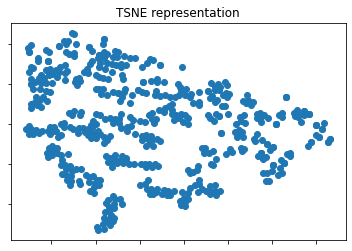

In [22]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

#Plot the t-SNE output
fig, ax = plt.subplots()
ax.plot(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))[:,0], tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))[:,1], 'o')
ax.set_title('TSNE representation')
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

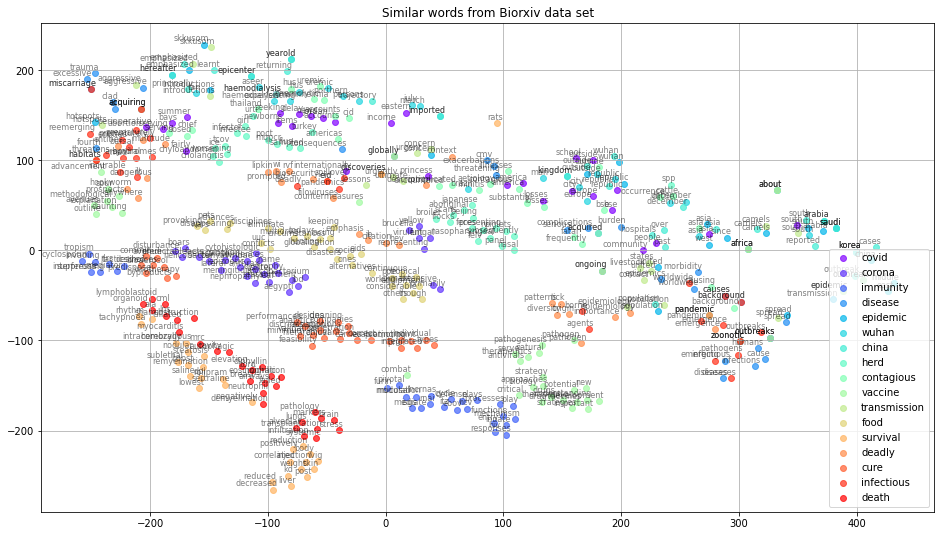

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm



def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

mplcursors.cursor(hover=True)
tsne_plot_similar_words('Similar words from Biorxiv data set', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

# Implement a BERT search engine 

Cred to Julien Heiduk (https://www.kaggle.com/zoupet/covid-19-search-engine-with-bert) for the initial idea of using a BERT search engine.

In [24]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:17<00:00, 23.3MB/s]
/usr/local/lib/python3.6/dist-packages/sentence_transformers/SentenceTransformer.py:57: ResourceWarning: unclosed file <_io.BufferedWriter name='/root/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip/model.zip'>
  http_get(model_url, zip_save_path)


In [0]:
question_embedding = model.encode(['What is known about transmission, incubation, and environmental stability?'])

queries = [       "Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",
                  "How long is the incubation period for the virus?",
                  "Can the virus be transmitted asymptomatically or during the incubation period?",
                  "How does weather, heat, and humidity affect the tramsmission of 2019-nCoV?",
                  "How long can the 2019-nCoV virus remain viable on common surfaces?"
              ]
query_embeddings = model.encode(queries)

In [14]:
abstract_embeddings = model.encode(df_noncomm.text.values)

print(abstract_embeddings)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity

closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = sc.spatial.distance.cdist([query_embedding], abstract_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        print(df_noncomm['text'][idx].strip(), "\n(Score: %.4f)" % (1-distance),"\n")





Query: Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?

Top 5 most similar sentences in corpus:
To assess the effects of hepatitis B virus (HBV) on the expression of host α-1,2-mannosidases and determine the underlying mechanisms. 
(Score: 0.7361) 

Ebolaviruses constitute a public health threat, particularly in Central and Western Africa. Host cell factors required for spread of ebolaviruses may serve as targets for antiviral intervention. Lectins, TAM receptor tyrosine kinases (Tyro3, Axl, Mer), T cell immunoglobulin and mucin domain (TIM) proteins, integrins, and Niemann-Pick C1 (NPC1) have been reported to promote entry of ebolaviruses into certain cellular systems. However, the factors used by ebolaviruses to invade macrophages, major viral targets, are poorly defined. Here, we show that mannose-specific lectins, TIM-1 and Axl augment entry into certain cell lines but do not contribute to Ebola virus (EBOV)-glycoprotein (GP)-driven t

# Implement a BERT summarizer

In [0]:
from summarizer import Summarizer


In [16]:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity and summarize their contents
model = Summarizer()
closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = sc.spatial.distance.cdist([query_embedding], abstract_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        result = model(df_noncomm['text'][idx], min_length=60)
        full = ''.join(result)
        print(df_noncomm['text'][idx].strip(), "\n(Score: %.4f)" % (1-distance),"\n")
        print("\nSummary of the paper containing the sentence: ", full, "\n")





Query: Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?

Top 5 most similar sentences in corpus:
To assess the effects of hepatitis B virus (HBV) on the expression of host α-1,2-mannosidases and determine the underlying mechanisms. 
(Score: 0.7361) 


Summarization of the paper containing the sentence:  To assess the effects of hepatitis B virus (HBV) on the expression of host α-1,2-mannosidases and determine the underlying mechanisms. 

Ebolaviruses constitute a public health threat, particularly in Central and Western Africa. Host cell factors required for spread of ebolaviruses may serve as targets for antiviral intervention. Lectins, TAM receptor tyrosine kinases (Tyro3, Axl, Mer), T cell immunoglobulin and mucin domain (TIM) proteins, integrins, and Niemann-Pick C1 (NPC1) have been reported to promote entry of ebolaviruses into certain cellular systems. However, the factors used by ebolaviruses to invade macrophages, major viral targe


# Another BERT pretrained Q&A

In [0]:
"""
Download pre-trained QA model
"""

import torch
from transformers import BertTokenizer
from transformers import BertForQuestionAnswering

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

BERT_SQUAD = 'bert-large-uncased-whole-word-masking-finetuned-squad'

model = BertForQuestionAnswering.from_pretrained(BERT_SQUAD)
tokenizer = BertTokenizer.from_pretrained(BERT_SQUAD)

model = model.to(torch_device)
#model.eval()


In [19]:

question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"

input_ids = tokenizer.encode(question, text)
token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([token_type_ids]))

all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
answer = ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])

print(answer)


a nice puppet
